# PROGETTO MLDM

## IMPORT MODULES

In [1]:
import os
import sys
assert sys.version_info >= (3, 5)

!pip install ydata-profiling optuna-integration

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 356.2/356.2 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.4/93.4 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.8/104.8 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 686.1/686.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 9.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.0/233.0 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.0 MB/s eta 0:00:00
  Created wheel for htmlmin: filename=htmlmin-0.1.12-py3-none-any.whl size=27080 sha256=950860e90fac470efcb1ab09ae0d412678d31c79602ee9acadac2df15fe4b3b0
  Stored in directory: /root/.cache/pip/wheels/dd/91/29/a79cecb328d01739e64017b6fb9a1ab9d8cb1853098ec5966d
Successfully built htmlmin


In [2]:
from ydata_profiling import ProfileReport

import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import graphviz

import xgboost

from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.datasets import make_moons
from sklearn.ensemble import (
    RandomForestClassifier,
    VotingClassifier,
    BaggingClassifier,
    AdaBoostClassifier,
    StackingClassifier
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    ConfusionMatrixDisplay,
    f1_score
    )
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    StratifiedKFold,
    cross_val_score,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import (
    StandardScaler,
    MinMaxScaler,
    OneHotEncoder,
    FunctionTransformer
)
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz


from joblib import dump, load

import optuna
from optuna.integration import OptunaSearchCV
from optuna.distributions import (
    IntDistribution ,
    CategoricalDistribution,
    FloatDistribution,
    LogUniformDistribution,
    UniformDistribution
    )

## DATASET LOAD



In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
DATA_PATH = "/content/drive/MyDrive/mldm/"
CSV_NAME = "bank-additional-full.csv"

dataset = pd.read_csv(DATA_PATH + CSV_NAME, delimiter=";")

## FEATURE EXPLORATION

### Basic Dataset Info

In [5]:
dataset.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [6]:
dataset.tail()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41187,74,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,3,999,1,failure,-1.1,94.767,-50.8,1.028,4963.6,no


In [7]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [8]:
dataset.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [9]:
dict = {"nunique": dataset.nunique(), "type": dataset.dtypes, "nan": dataset.isnull().sum()}

info = pd.DataFrame.from_dict(dict)

info

,nunique,type,nan
age,78,int64,0
job,12,object,0
marital,4,object,0
education,8,object,0
default,3,object,0
housing,3,object,0
loan,3,object,0
contact,2,object,0
month,10,object,0
day_of_week,5,object,0


### Dataset overview

In [10]:
profile = ProfileReport(dataset, title ="dataset report", explorative=True)

In [11]:
profile.to_notebook_iframe()

Output hidden; open in https://colab.research.google.com to view.

### Unknown-values handle

In [10]:
dataset = dataset.replace("unknown", np.nan)

dataset

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,NaN,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,...,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,...,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


### Drop columns

In [11]:
dataset.drop(columns=["default", "nr.employed"], inplace=True)

### Binary columns handle

In [12]:
# labda functions for transform categorical binary function in 0-1 values
dataset["pdays"] = dataset["pdays"].apply(lambda x: 0 if x == 999 else 1)
dataset["housing"] = dataset["housing"].apply(lambda x: 0 if x == 'no' else 1)
dataset["loan"] = dataset["loan"].apply(lambda x: 0 if x == 'no' else 1)
dataset["contact"] = dataset["contact"].apply(lambda x: 0 if x == 'telephone' else 1)
dataset["y"] = dataset["y"].apply(lambda x: 0 if x == 'no' else 1)


### Dividing features by semantic type

In [13]:
BINARY_COLS = [col for col, val in dataset.nunique().items() if val == 2]
BINARY_COLS

['housing', 'loan', 'contact', 'pdays', 'y']

In [14]:
BINARY_THRESHOLD = 2
CATEGORICAL_COLS = [
    col
    for col in dataset.select_dtypes(include='object')
    if dataset[col].nunique() > BINARY_THRESHOLD

]
CATEGORICAL_COLS

['job', 'marital', 'education', 'month', 'day_of_week', 'poutcome']

In [15]:
NUMERICAL_COLS = [
    col
    for col in dataset.select_dtypes(include=['int64', 'float64'] )
    if dataset[col].nunique() > BINARY_THRESHOLD
]
NUMERICAL_COLS

['age',
 'duration',
 'campaign',
 'previous',
 'emp.var.rate',
 'cons.price.idx',
 'cons.conf.idx',
 'euribor3m']

## FEATURE ENGENEERING

### Removing duplicates

In [16]:
dataset.drop_duplicates()

,age,job,marital,education,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,y
0,56,housemaid,married,basic.4y,0,0,0,may,mon,261,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,0
1,57,services,married,high.school,0,0,0,may,mon,149,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,0
2,37,services,married,high.school,1,0,0,may,mon,226,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,0
3,40,admin.,married,basic.6y,0,0,0,may,mon,151,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,0
4,56,services,married,high.school,0,1,0,may,mon,307,1,0,0,nonexistent,1.1,93.994,-36.4,4.857,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,retired,married,professional.course,1,0,1,nov,fri,334,1,0,0,nonexistent,-1.1,94.767,-50.8,1.028,1
41184,46,blue-collar,married,professional.course,0,0,1,nov,fri,383,1,0,0,nonexistent,-1.1,94.767,-50.8,1.028,0
41185,56,retired,married,university.degree,1,0,1,nov,fri,189,2,0,0,nonexistent,-1.1,94.767,-50.8,1.028,0
41186,44,technician,married,professional.course,0,0,1,nov,fri,442,1,0,0,nonexistent,-1.1,94.767,-50.8,1.028,1


### Division training and validation set

In [17]:
TRAIN_SIZE = 0.8
RANDOM_STATE = 2024
TARGET = "y"

BINARY_COLS.remove(TARGET)

X_data, y_data = dataset.drop(columns=[TARGET]), dataset[TARGET]

# Split dataset
X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

### Preprocessor

In [18]:
# Logical pipeline with the SimpleImputer
logical_pipeline = Pipeline(
    [("imputer", SimpleImputer(strategy="most_frequent"))]
    )

In [19]:
# Categorical pipeline with the SimpleImputer and OneHotEncoder
categorical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ( "one_hot_encoder", OneHotEncoder(handle_unknown="infrequent_if_exist"))
    ]
)

In [20]:
# Numerical pipeline with the SimpleImputer and MinMaxScaler
numerical_pipeline = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", MinMaxScaler(), )
    ]
)

In [21]:
# Preprocessor with the ColumnTransformer and the defined pipelines

preprocessor = ColumnTransformer(
    transformers= [
        ("log", logical_pipeline, BINARY_COLS),
        ("cat", categorical_pipeline, CATEGORICAL_COLS),
        ("num", numerical_pipeline, NUMERICAL_COLS)
        ]
)

In [22]:
preprocessor

ColumnTransformer(transformers=[('log',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent'))]),
                                 ['housing', 'loan', 'contact', 'pdays']),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('one_hot_encoder',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                 ['job', 'marital', 'education', 'month',
                                  'day_of_week', 'poutcome']),
                                ('num',
                                 Pipeline(steps=[('imputer', SimpleImputer()),
                                                 ('scaler', MinMaxScaler())]),
                                 ['age', 'duration', 'campaign', 'previous',
                                  'emp.var.rate', 'cons.price.idx',
                                  'cons.conf.idx', 'euribor3m'])])

## Model

### Function for model result analysis

In [23]:
def result_analysis(pipeline):
  score = (pipeline.score(X_val, y_val))
  print("score = " + str(score))

  y_pred = pipeline.predict(X_val)

  c = confusion_matrix(y_val, y_pred)
  disp = ConfusionMatrixDisplay(confusion_matrix=c)
  disp.plot()

  plt.show()

  f1 = f1_score(y_val, y_pred)
  print('f1 = '+str(f1))

  print("\n"+"Classification Report:")
  print(classification_report(y_val, y_pred ))

### Random Forest Pipeline

In [24]:
rndf_clf = RandomForestClassifier(random_state=RANDOM_STATE)

# Define the classification pipeline with the preprocessor and the classifier
pipeline_rndf_clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", rndf_clf)
        ]
)

In [25]:
pipeline_rndf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['housing', 'loan', 'contact',
                                                   'pdays']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['job', 'marital',
                                                   'education', 'month',
                                                   'day_of_week', 'poutcome']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'duration',
                                                   'campaign', 'previous',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx',
                                                   'euribor3m'])])),
                ('classifier', RandomForestClassifier(random_state=2024))])

score = 0.9169701383831027


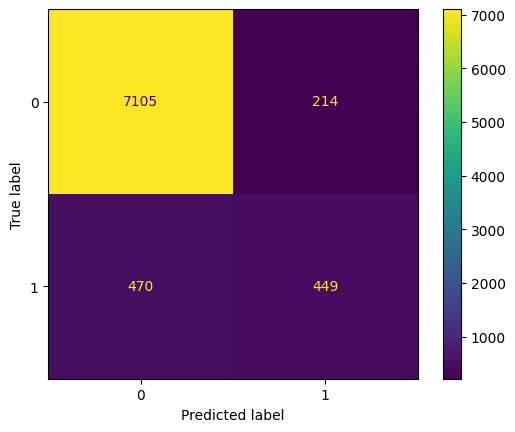

f1 = 0.5676359039190897

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95      7319
           1       0.68      0.49      0.57       919

    accuracy                           0.92      8238
   macro avg       0.81      0.73      0.76      8238
weighted avg       0.91      0.92      0.91      8238



In [26]:
result_analysis(pipeline_rndf_clf)

### Xgboost Pipeline

In [27]:
xgb_clf = xgboost.XGBClassifier(random_state=RANDOM_STATE)

# Define the classification pipeline
pipeline_xgb_clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", xgb_clf)
        ]
)

In [28]:
pipeline_xgb_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['housing', 'loan', 'contact',
                                                   'pdays']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['job', 'marital',
                                                   'educ...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=2024, ...))])

score = 0.9195193008011653


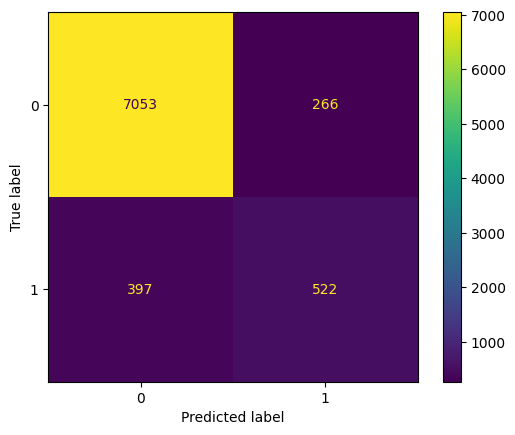

f1 = 0.6115992970123023

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.96      0.96      7319
           1       0.66      0.57      0.61       919

    accuracy                           0.92      8238
   macro avg       0.80      0.77      0.78      8238
weighted avg       0.91      0.92      0.92      8238



In [29]:
result_analysis(pipeline_xgb_clf)

### Support vector machine Pipeline

In [ ]:
svm_clf = SVC(kernel="rbf", probability=True, random_state=RANDOM_STATE)

# Define the classification pipeline

pipeline_svm_clf = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", svm_clf)
        ]
)

In [ ]:
pipeline_svm_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['housing', 'loan', 'contact',
                                                   'pdays']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['job', 'marital',
                                                   'education', 'month',
                                                   'day_of_week', 'poutcome']),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   MinMaxScaler())]),
                                                  ['age', 'duration',
                                                   'campaign', 'previous',
                                                   'emp.var.rate',
                                                   'cons.price.idx',
                                                   'cons.conf.idx',
                                                   'euribor3m'])])),
                ('classifier', SVC(probability=True, random_state=2024))])

score = 0.9031318281136198


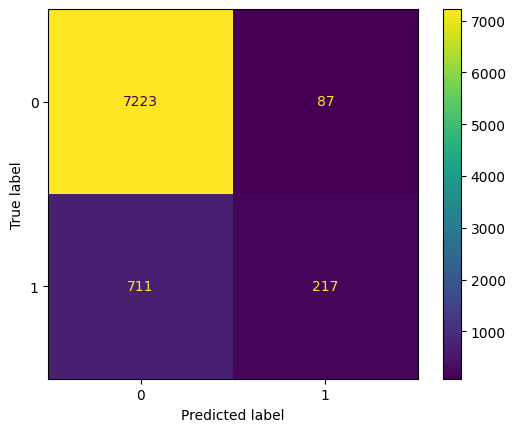

f1 = 0.35227272727272724

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      7310
           1       0.71      0.23      0.35       928

    accuracy                           0.90      8238
   macro avg       0.81      0.61      0.65      8238
weighted avg       0.89      0.90      0.88      8238



In [ ]:
result_analysis(pipeline_svm_clf)

### Stacking Pipeline

In [ ]:
estimators = [
    ("ada", AdaBoostClassifier(random_state=2023)),
    ("xgb", xgboost.XGBClassifier(n_estimators = 200, max_depth=1, random_state=RANDOM_STATE))

]

stacking_clf = StackingClassifier(estimators=estimators,
                                  final_estimator=RandomForestClassifier(random_state=RANDOM_STATE), cv=2)


In [ ]:
pipeline_stacking = Pipeline(
    [
        ("preprocessor", preprocessor),
        ("classifier", stacking_clf)
        ]
)

In [ ]:
pipeline_stacking.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('log',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['housing', 'loan', 'contact',
                                                   'pdays']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('one_hot_encoder',
                                                                   OneHotEncoder(handle_unknown='infrequent_if_exist'))]),
                                                  ['job', 'marital',
                                                   'educ...
                                                               interaction_constraints=None,
                                                               learning_rate=None,
                                                               max_bin=None,
                                                               max_cat_threshold=None,
                                                               max_cat_to_onehot=None,
                                                               max_delta_step=None,
                                                               max_depth=1,
                                                               max_leaves=None,
                                                               min_child_weight=None,
                                                               missing=nan,
                                                               monotone_constraints=None,
                                                               multi_strategy=None,
                                                               n_estimators=200,
                                                               n_jobs=None,
                                                               num_parallel_tree=None,
                                                               random_state=2024, ...))],
                                    final_estimator=RandomForestClassifier(random_state=2024)))])

score = 0.9077445982034474


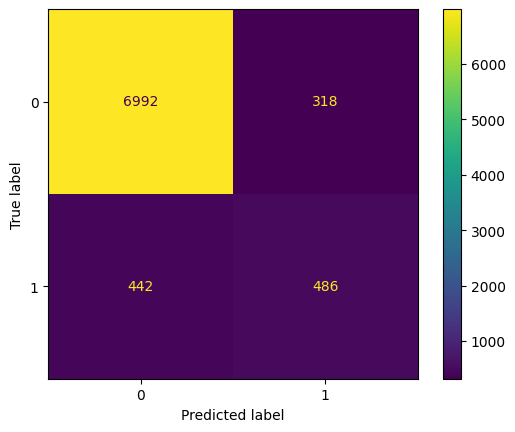

f1 = 0.5612009237875288

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      7310
           1       0.60      0.52      0.56       928

    accuracy                           0.91      8238
   macro avg       0.77      0.74      0.75      8238
weighted avg       0.90      0.91      0.90      8238



In [ ]:
result_analysis(pipeline_stacking)

## Optuna config

In [30]:
study = optuna.create_study(
    study_name="client_classification",
    storage="sqlite:///client_classification.sqlite3",
    load_if_exists=True,
    direction="maximize"

)

[I 2024-07-19 11:19:55,881] A new study created in RDB with name: client_classification


In [31]:
N_TRIALS = 20
N_JOBS = 8
CROSS_VALIDATION = 3
VERBOSE = 1

### Optuna - random forest

In [32]:
optuna_param_distributions_rndf = {
    "classifier__n_estimators": IntDistribution(100, 400),
    "classifier__max_depth": IntDistribution(10, 25),
    "classifier__min_samples_split": IntDistribution(5, 20),
    "classifier__min_samples_leaf": IntDistribution(5, 20),
    "classifier__max_features": FloatDistribution (0.1, 1.0),
    "classifier__bootstrap": CategoricalDistribution([True, False]),
    "classifier__criterion": CategoricalDistribution(["gini", "entropy"])
}

In [33]:
optuna_search_rndf = OptunaSearchCV(
    pipeline_rndf_clf,
    param_distributions= optuna_param_distributions_rndf,
    n_trials = N_TRIALS,
    random_state = RANDOM_STATE,
    n_jobs = N_JOBS,
    cv = CROSS_VALIDATION,
    study = study,
    verbose = VERBOSE
)

<ipython-input-33-3baec4899531>:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_rndf = OptunaSearchCV(


In [ ]:
optuna_search_rndf.fit(X_train, y_train)

INFO:optuna_integration.sklearn:Searching the best hyperparameters using 32950 samples...
[I 2024-07-16 20:37:34,617] Trial 2 finished with value: 0.9135356636159124 and parameters: {'classifier__n_estimators': 101, 'classifier__max_depth': 22, 'classifier__min_samples_split': 16, 'classifier__min_samples_leaf': 17, 'classifier__max_features': 0.6923839619997892, 'classifier__bootstrap': True, 'classifier__criterion': 'entropy'}. Best is trial 2 with value: 0.9135356636159124.
[I 2024-07-16 20:38:59,141] Trial 3 finished with value: 0.911745114174443 and parameters: {'classifier__n_estimators': 331, 'classifier__max_depth': 22, 'classifier__min_samples_split': 19, 'classifier__min_samples_leaf': 11, 'classifier__max_features': 0.19755157863890477, 'classifier__bootstrap': True, 'classifier__criterion': 'entropy'}. Best is trial 2 with value: 0.9135356636159124.
[I 2024-07-16 20:39:11,738] Trial 4 finished with value: 0.9131411503845456 and parameters: {'classifier__n_estimators': 304, 

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('log',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['housing',
                                                                            'loan',
                                                                            'contact',
                                                                            'pdays']),
                                                                          ('cat',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('one_hot_encoder',
                                                                                            OneHotEncoder(handle_unknown='infrequent_if_exi...
                                    'classifier__max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None),
                                    'classifier__min_samples_leaf': IntDistribution(high=20, log=False, low=5, step=1),
                                    'classifier__min_samples_split': IntDistribution(high=20, log=False, low=5, step=1),
                                    'classifier__n_estimators': IntDistribution(high=400, log=False, low=100, step=1)},
               random_state=2024,
               study=<optuna.study.study.Study object at 0x7b1c95da88e0>,
               verbose=1)

In [ ]:
optuna_search_rndf.best_params_

{'classifier__n_estimators': 352,
 'classifier__max_depth': 12,
 'classifier__min_samples_split': 19,
 'classifier__min_samples_leaf': 5,
 'classifier__max_features': 0.37923674252754347,
 'classifier__bootstrap': False,
 'classifier__criterion': 'gini'}

score = 0.9221898519058024


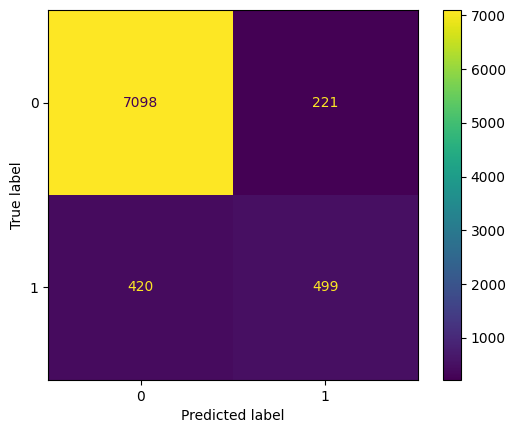

f1 = 0.6089078706528371

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.96      7319
           1       0.69      0.54      0.61       919

    accuracy                           0.92      8238
   macro avg       0.82      0.76      0.78      8238
weighted avg       0.92      0.92      0.92      8238



In [ ]:
result_analysis(optuna_search_rndf)

### Optuna - xgboost

In [ ]:
optuna_param_distributions_xgb = {
    "classifier__n_estimators": IntDistribution(50, 300),
    "classifier__max_depth": IntDistribution(3, 15),
    "classifier__learning_rate": FloatDistribution(0.01, 0.3),
    "classifier__subsample": FloatDistribution(0.5, 1.0),
    "classifier__colsample_bytree": FloatDistribution(0.5, 1.0),
    "classifier__gamma": FloatDistribution(0, 5),
    "classifier__min_child_weight": IntDistribution(1, 10)
}

In [ ]:
optuna_search_xgb = OptunaSearchCV(
    pipeline_xgb_clf,
    param_distributions= optuna_param_distributions_xgb,
    n_trials = N_TRIALS,
    random_state = RANDOM_STATE,
    n_jobs = N_JOBS,
    cv = CROSS_VALIDATION,
    study = study,
    verbose = VERBOSE
)

<ipython-input-43-92a0927fed3b>:1: ExperimentalWarning: OptunaSearchCV is experimental (supported from v0.17.0). The interface can change in the future.
  optuna_search_xgb = OptunaSearchCV(


In [ ]:
optuna_search_xgb.fit(X_train, y_train)

INFO:optuna_integration.sklearn:Searching the best hyperparameters using 32950 samples...
[I 2024-07-16 20:52:46,951] Trial 22 finished with value: 0.912837628932237 and parameters: {'classifier__n_estimators': 64, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.27373450606906335, 'classifier__subsample': 0.9007287137513672, 'classifier__colsample_bytree': 0.6745462831542738, 'classifier__gamma': 1.4648983601725951, 'classifier__min_child_weight': 9}. Best is trial 12 with value: 0.9150834688414816.
[I 2024-07-16 20:52:48,042] Trial 24 finished with value: 0.9142033428386322 and parameters: {'classifier__n_estimators': 55, 'classifier__max_depth': 5, 'classifier__learning_rate': 0.10665923023389144, 'classifier__subsample': 0.8388021226646084, 'classifier__colsample_bytree': 0.7644049989593219, 'classifier__gamma': 0.3288703016112908, 'classifier__min_child_weight': 3}. Best is trial 12 with value: 0.9150834688414816.
[I 2024-07-16 20:52:48,310] Trial 20 finished with value:

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('log',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['housing',
                                                                            'loan',
                                                                            'contact',
                                                                            'pdays']),
                                                                          ('cat',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('one_hot_encoder',
                                                                                            OneHotEncoder(handle_unknown='infrequent_if_exi...
                                    'classifier__max_depth': IntDistribution(high=15, log=False, low=3, step=1),
                                    'classifier__min_child_weight': IntDistribution(high=10, log=False, low=1, step=1),
                                    'classifier__n_estimators': IntDistribution(high=300, log=False, low=50, step=1),
                                    'classifier__subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)},
               random_state=2024,
               study=<optuna.study.study.Study object at 0x7b1c95da88e0>,
               verbose=1)

In [ ]:
optuna_search_xgb.best_params_

{'classifier__n_estimators': 147,
 'classifier__max_depth': 6,
 'classifier__learning_rate': 0.03150295190078392,
 'classifier__subsample': 0.5061617386203506,
 'classifier__colsample_bytree': 0.9996814768979743,
 'classifier__gamma': 4.804910312509943,
 'classifier__min_child_weight': 1}

score = 0.9236465161446953


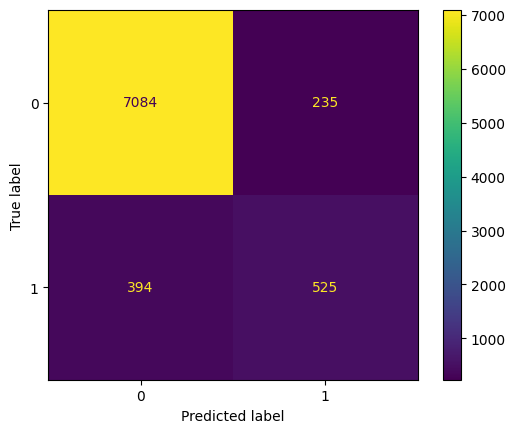

f1 = 0.6253722453841573

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96      7319
           1       0.69      0.57      0.63       919

    accuracy                           0.92      8238
   macro avg       0.82      0.77      0.79      8238
weighted avg       0.92      0.92      0.92      8238



In [ ]:
result_analysis(optuna_search_xgb)

## Under-Resampling

In [ ]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=RANDOM_STATE)
X_under_resampled, y_under_resampled = rus.fit_resample(X_train, y_train)

X_under_resampled.shape

(7442, 18)

In [ ]:
optuna_search_rndf.fit(X_under_resampled, y_under_resampled)

INFO:optuna_integration.sklearn:Searching the best hyperparameters using 7442 samples...
[I 2024-07-16 20:53:55,139] Trial 41 finished with value: 0.8868582409104896 and parameters: {'classifier__n_estimators': 122, 'classifier__max_depth': 18, 'classifier__min_samples_split': 11, 'classifier__min_samples_leaf': 7, 'classifier__max_features': 0.33507961354492594, 'classifier__bootstrap': False, 'classifier__criterion': 'gini'}. Best is trial 28 with value: 0.9153262793718788.
[I 2024-07-16 20:53:55,839] Trial 40 finished with value: 0.8871272206403072 and parameters: {'classifier__n_estimators': 119, 'classifier__max_depth': 18, 'classifier__min_samples_split': 11, 'classifier__min_samples_leaf': 7, 'classifier__max_features': 0.4026089499359372, 'classifier__bootstrap': False, 'classifier__criterion': 'gini'}. Best is trial 28 with value: 0.9153262793718788.
[I 2024-07-16 20:54:00,976] Trial 45 finished with value: 0.8789304087408389 and parameters: {'classifier__n_estimators': 264, '

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('log',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['housing',
                                                                            'loan',
                                                                            'contact',
                                                                            'pdays']),
                                                                          ('cat',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('one_hot_encoder',
                                                                                            OneHotEncoder(handle_unknown='infrequent_if_exi...
                                    'classifier__max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None),
                                    'classifier__min_samples_leaf': IntDistribution(high=20, log=False, low=5, step=1),
                                    'classifier__min_samples_split': IntDistribution(high=20, log=False, low=5, step=1),
                                    'classifier__n_estimators': IntDistribution(high=400, log=False, low=100, step=1)},
               random_state=2024,
               study=<optuna.study.study.Study object at 0x7b1c95da88e0>,
               verbose=1)

score = 0.8392813789754795


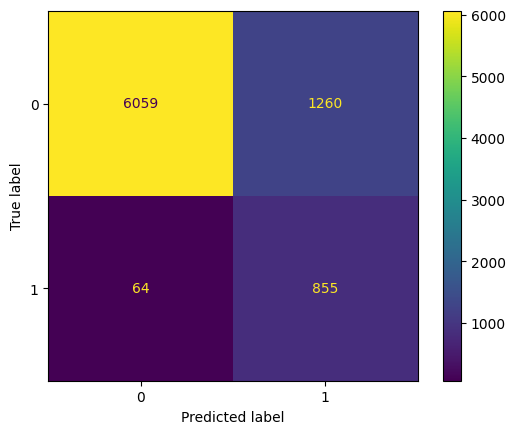

f1 = 0.5636123928806855

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.83      0.90      7319
           1       0.40      0.93      0.56       919

    accuracy                           0.84      8238
   macro avg       0.70      0.88      0.73      8238
weighted avg       0.92      0.84      0.86      8238



In [ ]:
result_analysis(optuna_search_rndf)

In [ ]:
optuna_search_xgb.fit(X_under_resampled, y_under_resampled)

INFO:optuna_integration.sklearn:Searching the best hyperparameters using 7442 samples...
[I 2024-07-16 20:55:50,978] Trial 61 finished with value: 0.8821554025648694 and parameters: {'classifier__n_estimators': 95, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.16713286581023634, 'classifier__subsample': 0.7028874079176819, 'classifier__colsample_bytree': 0.5936000458245455, 'classifier__gamma': 3.458589060067195, 'classifier__min_child_weight': 3}. Best is trial 28 with value: 0.9153262793718788.
[I 2024-07-16 20:55:51,368] Trial 65 finished with value: 0.8833645924076747 and parameters: {'classifier__n_estimators': 92, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.17887522705843667, 'classifier__subsample': 0.6853764249414582, 'classifier__colsample_bytree': 0.5757002112453874, 'classifier__gamma': 3.309486150357924, 'classifier__min_child_weight': 3}. Best is trial 28 with value: 0.9153262793718788.
[I 2024-07-16 20:55:51,806] Trial 60 finished with value: 0

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('log',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['housing',
                                                                            'loan',
                                                                            'contact',
                                                                            'pdays']),
                                                                          ('cat',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('one_hot_encoder',
                                                                                            OneHotEncoder(handle_unknown='infrequent_if_exi...
                                    'classifier__max_depth': IntDistribution(high=15, log=False, low=3, step=1),
                                    'classifier__min_child_weight': IntDistribution(high=10, log=False, low=1, step=1),
                                    'classifier__n_estimators': IntDistribution(high=300, log=False, low=50, step=1),
                                    'classifier__subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)},
               random_state=2024,
               study=<optuna.study.study.Study object at 0x7b1c95da88e0>,
               verbose=1)

score = 0.8594319009468318


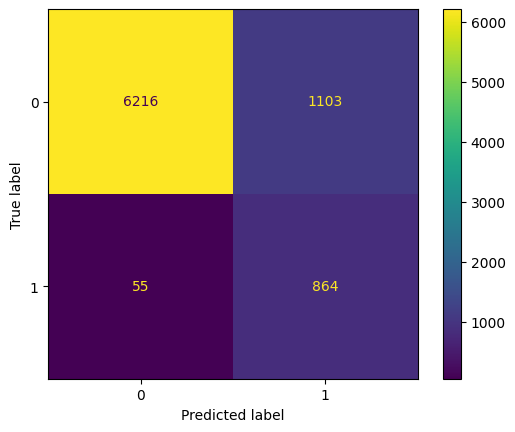

f1 = 0.5987525987525987

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.85      0.91      7319
           1       0.44      0.94      0.60       919

    accuracy                           0.86      8238
   macro avg       0.72      0.89      0.76      8238
weighted avg       0.93      0.86      0.88      8238



In [ ]:
result_analysis(optuna_search_xgb)

## Over-Resempling

In [ ]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_over_resampled, y_over_resampled = ros.fit_resample(X_train, y_train)

X_over_resampled.shape

(58458, 18)

In [ ]:
optuna_search_rndf.fit(X_over_resampled, y_over_resampled)

INFO:optuna_integration.sklearn:Searching the best hyperparameters using 58458 samples...
[I 2024-07-16 21:01:54,769] Trial 84 finished with value: 0.9265284477744706 and parameters: {'classifier__n_estimators': 235, 'classifier__max_depth': 20, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 10, 'classifier__max_features': 0.2746264139930604, 'classifier__bootstrap': True, 'classifier__criterion': 'entropy'}. Best is trial 84 with value: 0.9265284477744706.
[I 2024-07-16 21:04:44,746] Trial 80 finished with value: 0.9263744910876185 and parameters: {'classifier__n_estimators': 357, 'classifier__max_depth': 22, 'classifier__min_samples_split': 20, 'classifier__min_samples_leaf': 10, 'classifier__max_features': 0.27216784696469964, 'classifier__bootstrap': True, 'classifier__criterion': 'entropy'}. Best is trial 84 with value: 0.9265284477744706.
[I 2024-07-16 21:05:01,377] Trial 86 finished with value: 0.9268021485510965 and parameters: {'classifier__n_estimators':

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('log',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['housing',
                                                                            'loan',
                                                                            'contact',
                                                                            'pdays']),
                                                                          ('cat',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('one_hot_encoder',
                                                                                            OneHotEncoder(handle_unknown='infrequent_if_exi...
                                    'classifier__max_features': FloatDistribution(high=1.0, log=False, low=0.1, step=None),
                                    'classifier__min_samples_leaf': IntDistribution(high=20, log=False, low=5, step=1),
                                    'classifier__min_samples_split': IntDistribution(high=20, log=False, low=5, step=1),
                                    'classifier__n_estimators': IntDistribution(high=400, log=False, low=100, step=1)},
               random_state=2024,
               study=<optuna.study.study.Study object at 0x7b1c95da88e0>,
               verbose=1)

In [ ]:
optuna_search_rndf.best_params_

{'classifier__n_estimators': 359,
 'classifier__max_depth': 22,
 'classifier__min_samples_split': 20,
 'classifier__min_samples_leaf': 10,
 'classifier__max_features': 0.7744858272548917,
 'classifier__bootstrap': True,
 'classifier__criterion': 'entropy'}

score = 0.8957271182325808


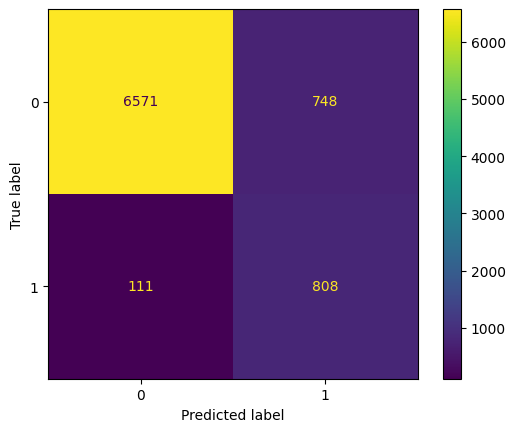

f1 = 0.6529292929292929

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.90      0.94      7319
           1       0.52      0.88      0.65       919

    accuracy                           0.90      8238
   macro avg       0.75      0.89      0.80      8238
weighted avg       0.93      0.90      0.91      8238



In [ ]:
result_analysis(optuna_search_rndf)

In [ ]:
optuna_search_xgb.fit(X_over_resampled, y_over_resampled)

INFO:optuna_integration.sklearn:Searching the best hyperparameters using 58458 samples...
[I 2024-07-16 21:22:13,314] Trial 104 finished with value: 0.9429333880734886 and parameters: {'classifier__n_estimators': 289, 'classifier__max_depth': 15, 'classifier__learning_rate': 0.07672153763892205, 'classifier__subsample': 0.8830577922018426, 'classifier__colsample_bytree': 0.8461304050501015, 'classifier__gamma': 0.8543085623024516, 'classifier__min_child_weight': 8}. Best is trial 104 with value: 0.9429333880734886.
[I 2024-07-16 21:22:18,169] Trial 106 finished with value: 0.9453966950631223 and parameters: {'classifier__n_estimators': 290, 'classifier__max_depth': 15, 'classifier__learning_rate': 0.077295400053505, 'classifier__subsample': 0.8811741046723848, 'classifier__colsample_bytree': 0.8332367522799403, 'classifier__gamma': 0.7200344252577784, 'classifier__min_child_weight': 8}. Best is trial 106 with value: 0.9453966950631223.
[I 2024-07-16 21:22:34,555] Trial 102 finished wit

OptunaSearchCV(cv=3,
               estimator=Pipeline(steps=[('preprocessor',
                                          ColumnTransformer(transformers=[('log',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent'))]),
                                                                           ['housing',
                                                                            'loan',
                                                                            'contact',
                                                                            'pdays']),
                                                                          ('cat',
                                                                           Pipeline(steps=[('imputer',
                                                                                            SimpleImputer(strategy='most_frequent')),
                                                                                           ('one_hot_encoder',
                                                                                            OneHotEncoder(handle_unknown='infrequent_if_exi...
                                    'classifier__max_depth': IntDistribution(high=15, log=False, low=3, step=1),
                                    'classifier__min_child_weight': IntDistribution(high=10, log=False, low=1, step=1),
                                    'classifier__n_estimators': IntDistribution(high=300, log=False, low=50, step=1),
                                    'classifier__subsample': FloatDistribution(high=1.0, log=False, low=0.5, step=None)},
               random_state=2024,
               study=<optuna.study.study.Study object at 0x7b1c95da88e0>,
               verbose=1)

In [ ]:
optuna_search_xgb.best_params_

{'classifier__n_estimators': 288,
 'classifier__max_depth': 15,
 'classifier__learning_rate': 0.07461040672079637,
 'classifier__subsample': 0.8730463726956393,
 'classifier__colsample_bytree': 0.8275822884822706,
 'classifier__gamma': 0.013730586573290182,
 'classifier__min_child_weight': 8}

score = 0.9085943190094683


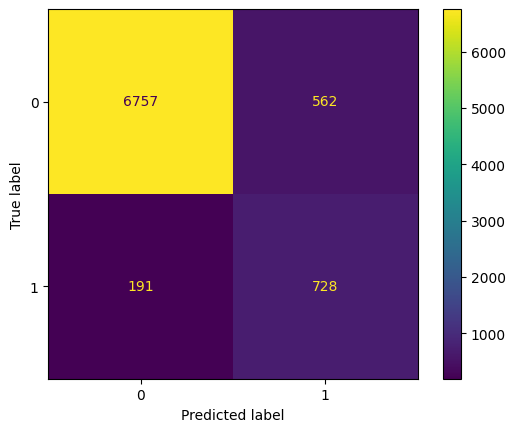

f1 = 0.6591217745586239

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      7319
           1       0.56      0.79      0.66       919

    accuracy                           0.91      8238
   macro avg       0.77      0.86      0.80      8238
weighted avg       0.93      0.91      0.92      8238



In [ ]:
result_analysis(optuna_search_xgb)